# Optimizing AI Trading Algorithms - Course Project


In this project you will practice optimizing various aspects of a machine learning model for predicting stock price movements. This will provide you with an opportunity to integrate the concepts covered in the course, such as data preprocessing and cleaning, hyperparameter tuning, detecting and addressing over-/under-fitting, model evaluation, and feature selection techniques. While you will use real-world data in this project, the goal is not necessarily to build a "winning" trading _strategy_. The goal of this course has been to equip you with the tools, techniques, concepts and insights you need to evaluate, optimize and monitor *your own* trading strategies.


## The Scenario

You are an analyst at a boutique investment firm tasked with coming up with a novel idea for investing in specific sectors of the industry. You've heard that the Utilities, Consumer Staples and Healthcare sectors are relatively resilient to economic shocks and recessions, and that stock market investors tend to flock to these sectors in times of uncertainty. You decide to take the [SPDR Healthcase Sector ETF (NYSEARCA: XLV)](https://www.sectorspdrs.com/mainfund/XLV) and try to model its returns' dynamics using a machine learning AI strategy. Your novel idea is to get data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) as a proxy for uncertainty in the market. You also decide to take a look at [Google Trends data](https://trends.google.com/trends/explore?date=all&geo=US&q=recession) for the search term "recession" in the United States, in order to try and see if there is any meaningful relationship between the general public's level of concern about a recession happening and the price movements of the Health Care Select Sector SPDR Fund.


You decide to train a binary **classification** model that merely attempts to predict the **direction** of XLV's 5-day price movements. In other words, you want to see if on any given day, with the above data in hand, you could reliably predict whether the price of XLV will increase or decrease over the next 5 trading days.

Run the cell below to `import` all the Python packages and modules you will be using throughout the project.

In [96]:
!pip install yfinance
!pip install ta

    torch (>=1.8.*)
           ~~~~~~^
    torch (>=1.8.*)
           ~~~~~~^


In [97]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

RANDOM_SEED = 42

## 1. Data Acquisition, Exploration, Cleaning and Preprocessing


In this section, you will download and inspect:

- daily data for the SPDR Healthcase Sector ETF (NYSEARCA: XLV)
- daily data for the volatility index (INDEXCBOE: VIX)
- monthly data from Google Trends for the search interest in the term "recession" in the United States

The goal is to make sure the data is clean, meaningful, and usable for selecting and engineering features.


### 1.1. Price and Volume Data for "XLV"


We have downloded daily data from **January 1st, 2004** to **March 31st, 2024** for the ticker **XLV** using the `yfinance` library and stored it in a CSV file named `xlv_data.csv`. Load this data into a Pandas DataFrame named `xlv_data`, making sure to set the index column to the first column of the CSV file (`Date`) and set `parse_dates=True`.


In [98]:
xlv_data = pd.read_csv('xlv_data.csv', index_col=0, parse_dates=True)
xlv_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,30.200001,30.440001,30.120001,30.219999,21.567184,628700
2004-01-05,30.400000,30.500000,30.139999,30.360001,21.667091,191500
2004-01-06,30.469999,30.480000,30.309999,30.450001,21.731337,289300
2004-01-07,30.450001,30.639999,30.309999,30.639999,21.866926,262300
2004-01-08,30.700001,30.700001,30.320000,30.510000,21.774158,214300


Use the `info()` and `describe()` methods to get an overview of how many rows of data there are in `xlv_data`, what columns are present and what their data types are, and what some basic statistics (mean, std, quartiles, min/max values) of the columns look like.


In [99]:
xlv_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 2004-01-02 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5094 non-null   float64
 1   High       5094 non-null   float64
 2   Low        5094 non-null   float64
 3   Close      5094 non-null   float64
 4   Adj Close  5094 non-null   float64
 5   Volume     5094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 278.6 KB


In [100]:
xlv_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,65.342311,65.730397,64.924197,65.349097,58.242299,7.228951e+06
std,36.695351,36.915853,36.477869,36.712468,37.932219,5.445803e+06
min,22.010000,22.290001,21.629999,21.879999,16.812475,5.870000e+04
25%,31.990000,32.132501,31.812500,31.990000,24.508568,3.790550e+06
50%,57.100000,57.400000,56.680000,57.010000,48.387001,6.582850e+06
75%,90.657503,91.077497,89.927500,90.557499,82.941315,9.559550e+06
max,147.919998,148.270004,147.679993,147.860001,147.729996,6.647020e+07


How many `NaN` rows are there in `xlv_data`?


In [101]:
xlv_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [102]:
answer = xlv_data.isna().values.sum()
print(f"Total NaN rows in the xlv_data: {answer}")

Total NaN rows in the xlv_data: 0


Take a look at the final five rows of `xlv_data`.


In [103]:
xlv_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,145.850006,146.220001,145.259995,145.440002,145.440002,5537200
2024-03-25,145.710007,145.860001,145.009995,145.240005,145.240005,5253000
2024-03-26,145.529999,145.940002,145.139999,145.770004,145.770004,6942400
2024-03-27,147.009995,147.710007,146.619995,147.710007,147.710007,8797400
2024-03-28,147.919998,148.229996,147.679993,147.729996,147.729996,8090200


Raw OHLC data is not suitable for training models. The absolute price level of a security is boundless in theory and not particularly menaningful. In the next section, you are going to engineer useful features from all of these columns. For now, as a visual sanity check, plot `Adj Close` as a line plot.


In [104]:
def plot_line(data, xlabel='Time', ylabel='Price', title='Prices vs Time', linestyle='solid'):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(data, linestyle = linestyle)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

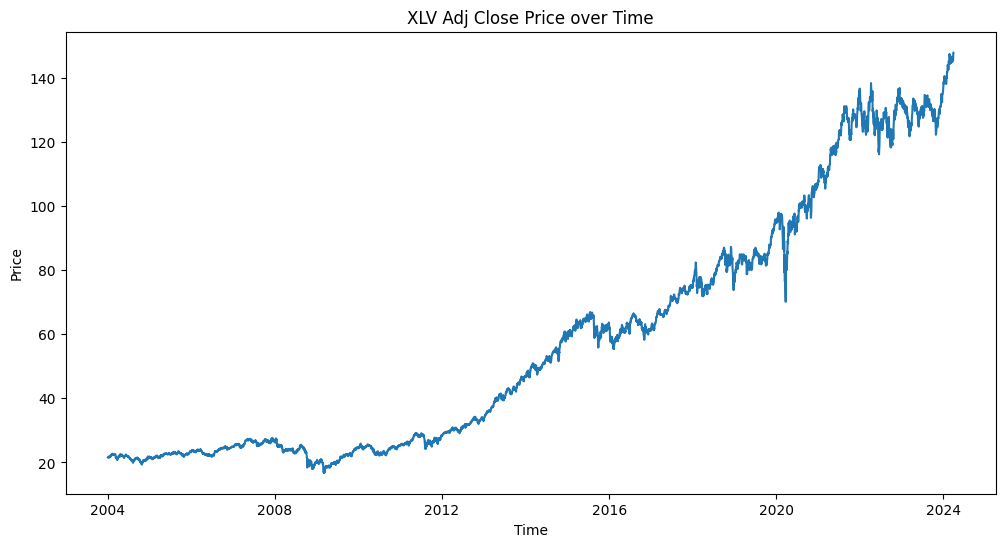

In [105]:
plot_line(
    xlv_data['Adj Close'], 
    xlabel='Time', 
    ylabel='Price', 
    title='XLV Adj Close Price over Time',
    linestyle='solid'
)

**Bonus**: The cell below plots the combined candlestick + volume chart for the last 15 months of data using Plotly.


In [106]:
data_since_2023 = xlv_data["2023-01-01":]

figure = make_subplots(specs=[[{"secondary_y": True}]])
figure.add_traces(
    go.Candlestick(
        x=data_since_2023.index,
        open=data_since_2023.Open,
        high=data_since_2023.High,
        low=data_since_2023.Low,
        close=data_since_2023.Close,
    ),
    secondary_ys=[True],
)
figure.add_traces(
    go.Bar(x=data_since_2023.index, y=data_since_2023.Volume, opacity=0.5),
    secondary_ys=[False],
)

figure.update_layout(
    title="XLV Candlestick Chart Since 2023",
    xaxis_title="Date",
    yaxis_title="Volume",
    yaxis2_title="Price",
    showlegend=False,
)
figure.update_yaxes(fixedrange=False)
figure.layout.yaxis2.showgrid = False
figure.show()

### 1.2. Data for The Volatility Index `VIX`


As before, we have downloaded daily data for the volatility index [(INDEXCBOE: VIX)](https://www.cboe.com/tradable_products/vix/) over the same time period using `yfinance` and provided it to you in a CSV file named `vix_data.csv`. Load the data into a variable named `vix_data`. Make sure to set the index and parse the dates correctly.


In [107]:
vix_data = pd.read_csv('vix_data.csv', index_col=0, parse_dates=True)
vix_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,17.959999,18.68,17.540001,18.219999,18.219999,0
2004-01-05,18.450001,18.49,17.440001,17.490000,17.490000,0
2004-01-06,17.660000,17.67,16.190001,16.730000,16.730000,0
2004-01-07,16.719999,16.75,15.500000,15.500000,15.500000,0
2004-01-08,15.420000,15.68,15.320000,15.610000,15.610000,0


Plot a line chart of the `Adj Close` value of the VIX using your method of choice (e.g. `plotly` or `matplotlib`).


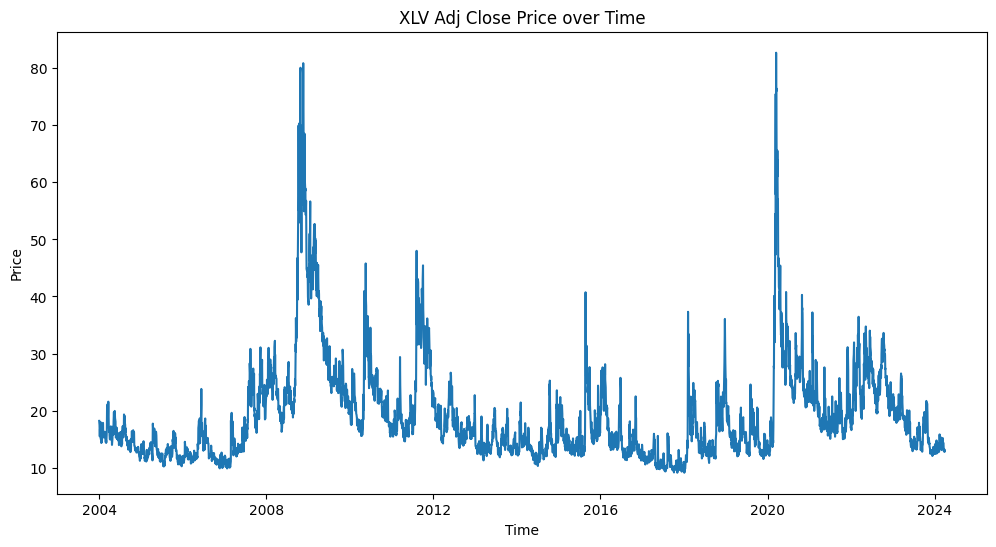

In [108]:
plot_line(
    vix_data['Adj Close'], 
    xlabel='Time',
    ylabel='Price',
    title='XLV Adj Close Price over Time',
    linestyle='solid'
)

### 1.3. Google Trends Data


The **monthly** evolution of search interest in the term "recession" in the U.S. over the period of interest (Jan. 2003 - Mar. 2024) from the Google Trends website has been provided to you as a CSV file. We will load this data using Pandas into a DataFrame named `google_trends_data`, set the index column of the DataFrame to the "`Month`" column from the CSV and have Pandas try and parse these dates automatically.

> Note: The "Month" column in the CSV is in "YYYY-MM" format.


In [109]:
google_trends_data = pd.read_csv('GoogleTrendsData.csv', index_col='Month')
google_trends_data.head()

,recession_search_trend
Month,
2004-01,4
2004-02,4
2004-03,5
2004-04,6
2004-05,4


As noted above, the CSV lists **monthly** search trends data and the `Month` column is in YYYY-MM format. How has Pandas interpreted and parsed these into specific dates? Take a look at `google_trends_data`'s index.


In [110]:
google_trends_data.index

Index(['2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06',
       '2004-07', '2004-08', '2004-09', '2004-10',
       ...
       '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11',
       '2023-12', '2024-01', '2024-02', '2024-03'],
      dtype='object', name='Month', length=243)

We would have liked to assign the data points to the last day of the respective months, as this data would have been available at the _end_ of each period. Shift the index column of `google_trends_data` to do this.

> Hint: You can use `pd.offsets.MonthEnd()` from Pandas.


In [111]:
google_trends_data.index = pd.to_datetime(google_trends_data.index, format="%Y-%m") + pd.offsets.MonthEnd(0)
google_trends_data.head()

,recession_search_trend
Month,
2004-01-31,4
2004-02-29,4
2004-03-31,5
2004-04-30,6
2004-05-31,4


Run the cell below to visualize this data as a line plot.

> **Note from Google:** "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."


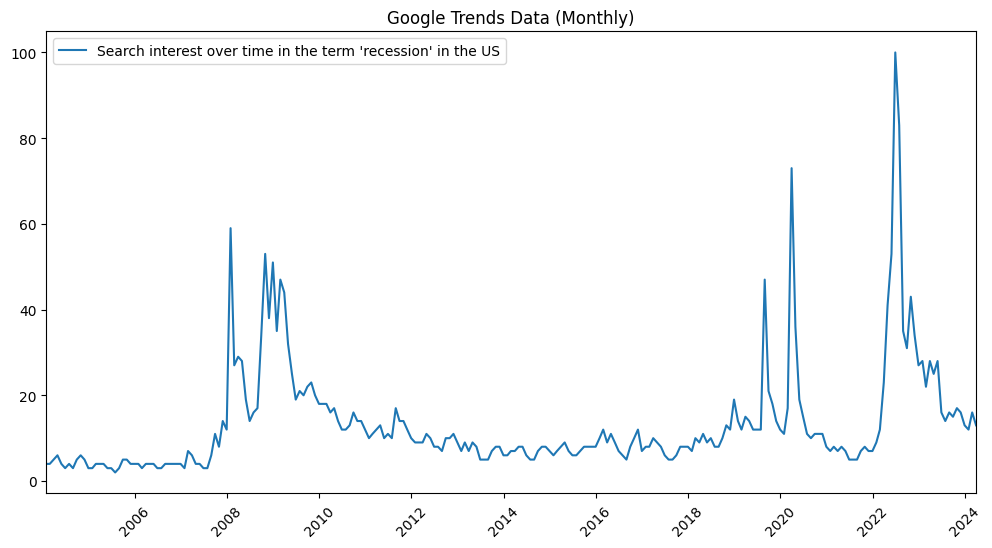

In [112]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(google_trends_data)
date_fmt = mdates.DateFormatter("%Y-%m")
plt.xlim(google_trends_data.index[0], google_trends_data.index[-1])
plt.xticks(rotation=45)
plt.title("Google Trends Data (Monthly)")
plt.legend(["Search interest over time in the term 'recession' in the US"])
plt.show()

But not every month-end is a trading day. Also, what value should the model train on for all the days in between month-ends? Below, we have provided you with code to convert the monthly data to daily and interpolate the end-of-month values to get all the in-between values. You will be using this new `google_trends_daily` data going forward.


In [113]:
google_trends_daily = google_trends_data.resample('D').asfreq().interpolate(method='linear')
google_trends_daily.head()

,recession_search_trend
Month,
2004-01-31,4.0
2004-02-01,4.0
2004-02-02,4.0
2004-02-03,4.0
2004-02-04,4.0


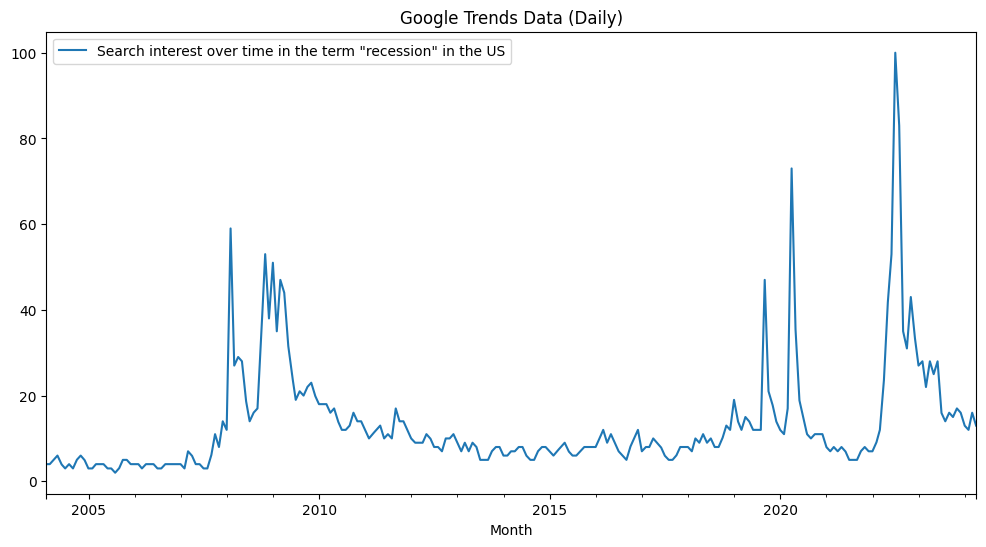

In [114]:
# The shape of the chart should not have changed
google_trends_daily.plot.line(title="Google Trends Data (Daily)", figsize=(12, 6)).legend(
    labels=['Search interest over time in the term "recession" in the US']
);

## 2. Feature Engineering and Analysis


In this section, you will create a new DataFrame called `data` which will house all of the features as well as the prediction target. Then you will analyze the features and look for potentially problematic features.

Start by running the cell below to create `data` as an empty DataFrame with just an index that matches `XLV`'s.


In [115]:
data = pd.DataFrame(index=xlv_data.index)
data.head()

""
Date
2004-01-02
2004-01-05
2004-01-06
2004-01-07
2004-01-08


### 2.1. Feature Engineering


#### 2.1.1. Month and Weekday


Add the `month` and `weekday` columns to `data` as categorical features (integer labels) from its index.


In [116]:
# # Add month and weekday columns as integer labels (categorical features)
# data['Month'] = data.index.month.astype('category')
# data['Weekday'] = data.index.weekday.astype('category')
data['Month'] = data.index.month.astype('int')
data['Weekday'] = data.index.weekday.astype('int')
data.head()

,Month,Weekday
Date,,
2004-01-02,1,4
2004-01-05,1,0
2004-01-06,1,1
2004-01-07,1,2
2004-01-08,1,3


You do not want to train a model using these columns as they are, because the numbers themselves and the inherent "order" of months and weekdays do not really have any significance, but the model may interpret them as meaningful. You could either (a) use one-hot encoding to turn each category to a separate binary feature, or (b) treat them as cyclical features. The choice is somewhat arbitrary and depends on how important a "feature" you believe the cyclicality to be.

Below, you will:

- Treat `month` as a cyclical feature, creating two features (`month_sin` and `month_cos`). (👉 See: [Trigonometric features](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#trigonometric-features))
- One-hot-encode `weekday` and create five additional features of type `int32` (one for each business day) with the `weekday` prefix. (👉 See: [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html))
- Make sure the original `month` and `weekday` columns are no longer present in `data`. (`drop()` them if necessary.)


In [117]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

data["month_sin"] = sin_transformer(12).fit_transform(data)["Month"]
data["month_cos"] = cos_transformer(12).fit_transform(data)["Month"]

# # Drop the original `month` column.
data.drop(['Month'], axis=1, inplace=True)

# Treat `weekday` as a "categorical" feature and one-hot-encode it.
data = pd.get_dummies(data, columns=['Weekday'], prefix='Weekday', dtype=int)

data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4
Date,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1
2004-01-05,0.5,0.866025,1,0,0,0,0
2004-01-06,0.5,0.866025,0,1,0,0,0
2004-01-07,0.5,0.866025,0,0,1,0,0
2004-01-08,0.5,0.866025,0,0,0,1,0


In [118]:
# # Treat `month` as a "cyclical" feature with a period of 12 months.
# data["month_sin"] = np.sin(2 * np.pi * data.index.month / 12)
# data["month_cos"] = np.cos(2 * np.pi * data.index.month / 12)
# data.head()

# # # Drop the original `month` column.
# data.drop(['Month'], axis=1, inplace=True)

# # Treat `weekday` as a "categorical" feature and one-hot-encode it.
# data = pd.get_dummies(data, columns=['Weekday'], prefix='Weekday', dtype=int)
# data.head()

#### 2.1.2. Historical Returns


Next, add features for historical returns of the XLV ETF from its `Adj Close` column. For each date, calculate rolling **simple** returns over the past 1, 5, 10 and 20 days. Create 4 columns in `data` named `ret_#d_hist` where `#` is the lookback period. The list `hist_ret_lookbacks` is provided if you wish to use it.


In [119]:
# # Create features for 1-day, 5-day, 10-day and 20-day historical returns
# hist_ret_lookbacks = [1, 5, 10, 20]
# ## YOUR CODE HERE ##
# for days in hist_ret_lookbacks:
#     prev_close = xlv_data['Adj Close'].shift(days)
#     data[f'ret_{days}d_hist'] = (xlv_data['Adj Close'] - prev_close) / prev_close

# data.head(10)

In [120]:
# Create features for 1-day, 5-day, 10-day and 20-day historical returns
hist_ret_lookbacks = [1, 5, 10, 20]
## YOUR CODE HERE ##
for days in hist_ret_lookbacks:
    data[f'ret_{days}d_hist'] = xlv_data['Adj Close'].pct_change(days)

data.head(10)

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist
Date,,,,,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1,NaN,NaN,NaN,NaN
2004-01-05,0.5,0.866025,1,0,0,0,0,0.004632,NaN,NaN,NaN
2004-01-06,0.5,0.866025,0,1,0,0,0,0.002965,NaN,NaN,NaN
2004-01-07,0.5,0.866025,0,0,1,0,0,0.006239,NaN,NaN,NaN
2004-01-08,0.5,0.866025,0,0,0,1,0,-0.004242,NaN,NaN,NaN
2004-01-09,0.5,0.866025,0,0,0,0,1,-0.006228,0.003309,NaN,NaN
2004-01-12,0.5,0.866025,1,0,0,0,0,-0.001649,-0.002964,NaN,NaN
2004-01-13,0.5,0.866025,0,1,0,0,0,-0.004295,-0.010181,NaN,NaN
2004-01-14,0.5,0.866025,0,0,1,0,0,0.005640,-0.010770,NaN,NaN


The cell below plots the histograms of the returns you just calculated. They should look normally distributed around zero.


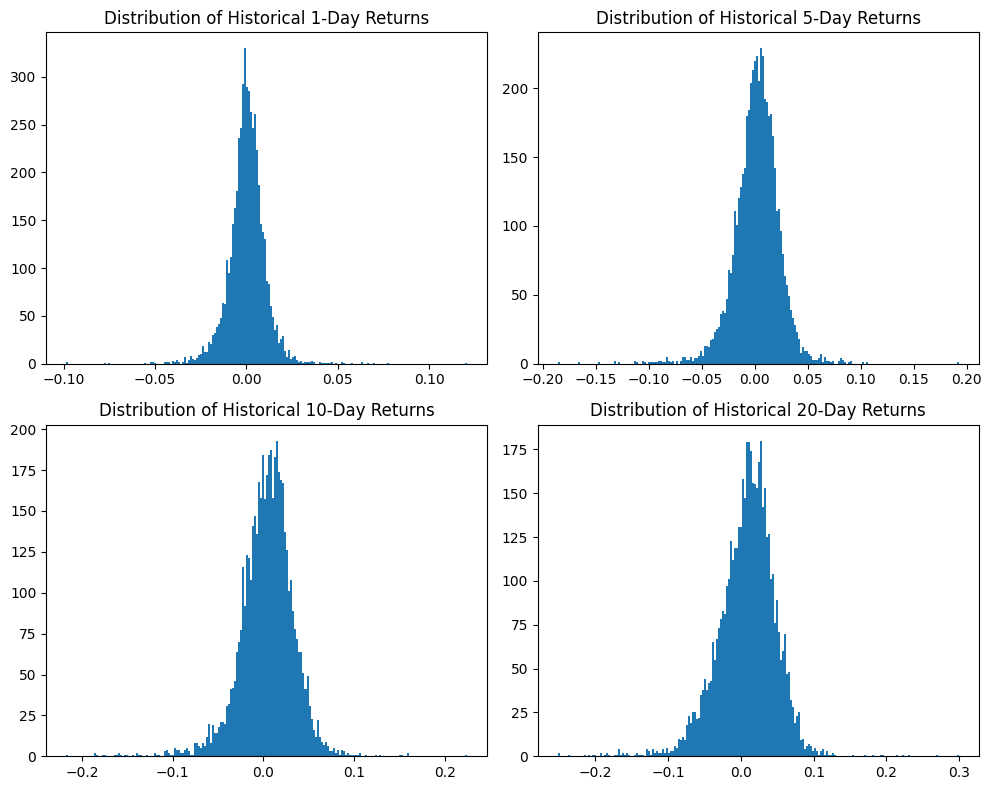

In [121]:
hist_ret_lookbacks = [1, 5, 10, 20] # In case it was deleted from the previous cell

fig, axs = plt.subplots(2, 2, figsize=(10, 8))


def plot_hist_returns(ax, data, col, title):
    ax.hist(data[col], bins=200)
    ax.set_title(title)


for i, n_days in enumerate(hist_ret_lookbacks):
    plot_hist_returns(
        axs[i // 2, i % 2], data, f"ret_{n_days}d_hist", f"Distribution of Historical {n_days}-Day Returns"
    )

plt.tight_layout()
plt.show()

#### 2.1.3. Trade Volumes

As trading volumes span several orders of magnitude, take the natural logarithm of `Volume` and use it as a feature instead. This helps emphasize variations in its lower range. Use `np.log()` and call this new feature `log_volume`.

**Note:** For tree-based models such as Decision Trees and Random Forests, scaling is not necessary. But feature scaling becomes critically important if you use other model types (e.g. distance-based models).


In [122]:
data["log_volume"] = np.log(xlv_data['Volume'])
data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume
Date,,,,,,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1,NaN,NaN,NaN,NaN,13.351409
2004-01-05,0.5,0.866025,1,0,0,0,0,0.004632,NaN,NaN,NaN,12.162643
2004-01-06,0.5,0.866025,0,1,0,0,0,0.002965,NaN,NaN,NaN,12.575219
2004-01-07,0.5,0.866025,0,0,1,0,0,0.006239,NaN,NaN,NaN,12.477244
2004-01-08,0.5,0.866025,0,0,0,1,0,-0.004242,NaN,NaN,NaN,12.275132


In [123]:
data['log_volume'].min(), data['log_volume'].max()

(10.980195005816189, 18.012264284889422)

#### 2.1.4. Technical Indicators

Add a feature named `ibs` which is calculated as (Close - Low) / (High - Low). This measure, a number between zero and one and sometimes referred to as the "Internal Bar Strength", denotes how "strong" the closing price is relative to the high and low prices within the same period.
> **Note:** Make sure to use `Close` (not `Adj Close`).

In [124]:
# Engineer the technical indicator "Internal Bar Strength" (IBS) 
#from XLV's price data
data["ibs"] = (xlv_data['Close']-xlv_data['Low'])/(xlv_data['High']-xlv_data['Low'])
data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs
Date,,,,,,,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1,NaN,NaN,NaN,NaN,13.351409,0.312496
2004-01-05,0.5,0.866025,1,0,0,0,0,0.004632,NaN,NaN,NaN,12.162643,0.611113
2004-01-06,0.5,0.866025,0,1,0,0,0,0.002965,NaN,NaN,NaN,12.575219,0.823537
2004-01-07,0.5,0.866025,0,0,1,0,0,0.006239,NaN,NaN,NaN,12.477244,1.000000
2004-01-08,0.5,0.866025,0,0,0,1,0,-0.004242,NaN,NaN,NaN,12.275132,0.500000


Run the cell below to add a few more technical indicators, including Bollinger Band features and indicators, as well as the Relative Strength Index (RSI).

In [125]:
# Get some more technical indicators using the `ta` library

indicator_bb = BollingerBands(close=xlv_data["Close"], window=20, window_dev=2)
indicator_rsi = RSIIndicator(close=xlv_data["Close"], window=14)

# Add Bollinger Bands features
data["bb_bbm"] = indicator_bb.bollinger_mavg()
data["bb_bbh"] = indicator_bb.bollinger_hband()
data["bb_bbl"] = indicator_bb.bollinger_lband()

# Add Bollinger Band high and low indicators
data["bb_bbhi"] = indicator_bb.bollinger_hband_indicator()
data["bb_bbli"] = indicator_bb.bollinger_lband_indicator()

# Add Width Size and Percentage Bollinger Bands
data["bb_bbw"] = indicator_bb.bollinger_wband()
data["bb_bbp"] = indicator_bb.bollinger_pband()

# Add RSI
data["rsi"] = indicator_rsi.rsi()

In [126]:
data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1,NaN,NaN,NaN,NaN,13.351409,0.312496,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2004-01-05,0.5,0.866025,1,0,0,0,0,0.004632,NaN,NaN,NaN,12.162643,0.611113,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2004-01-06,0.5,0.866025,0,1,0,0,0,0.002965,NaN,NaN,NaN,12.575219,0.823537,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2004-01-07,0.5,0.866025,0,0,1,0,0,0.006239,NaN,NaN,NaN,12.477244,1.000000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2004-01-08,0.5,0.866025,0,0,0,1,0,-0.004242,NaN,NaN,NaN,12.275132,0.500000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


#### 2.1.5. The Target of Prediction

Add the column `tgt_is_pos_ret_5d_fut` as type `int` to `data`, denoting whether forward-looking 5-day returns on each day are positive (a value of `1`) or negative (a value of `0`).
> **Note:** Again, as before, calculte **simple** returns from the `Adj Close` column of `xlv_data`.

In [127]:
# Create the prediction target: an integer indicating whether future 5-day returns are positive (1) or negative (0)
# Calculate forward-looking 5-day returns
# Create a binary target column: 1 if the forward return is positive, 0 if it's not
fl_5day = xlv_data['Adj Close'].shift(-5)
data['tgt_is_pos_ret_5d_fut'] = ((fl_5day - xlv_data['Adj Close']) > 0).astype(int)
data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut
Date,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1,NaN,NaN,NaN,NaN,13.351409,0.312496,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1
2004-01-05,0.5,0.866025,1,0,0,0,0,0.004632,NaN,NaN,NaN,12.162643,0.611113,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
2004-01-06,0.5,0.866025,0,1,0,0,0,0.002965,NaN,NaN,NaN,12.575219,0.823537,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
2004-01-07,0.5,0.866025,0,0,1,0,0,0.006239,NaN,NaN,NaN,12.477244,1.000000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0
2004-01-08,0.5,0.866025,0,0,0,1,0,-0.004242,NaN,NaN,NaN,12.275132,0.500000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0


Run the cells below to get an idea of how balanced the distribution of the target variable is throughout the data.

In [128]:
target_col_name = "tgt_is_pos_ret_5d_fut"
# Inspect the distribution of the target variable
target_value_counts = data[target_col_name].value_counts()
target_value_counts / len(data)

tgt_is_pos_ret_5d_fut
1    0.566156
0    0.433844
Name: count, dtype: float64

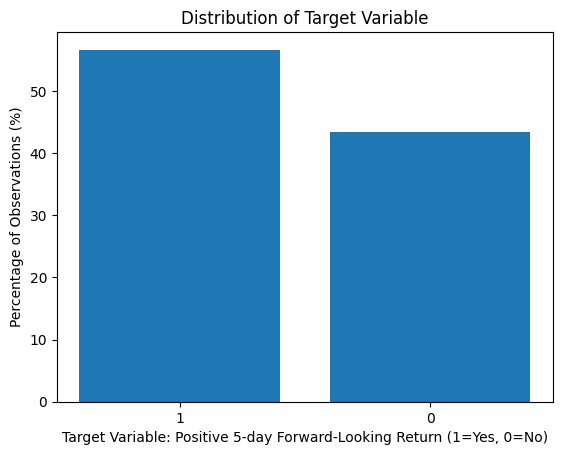

In [129]:
target_value_percentages = target_value_counts / len(data) * 100

plt.bar(target_value_percentages.index.astype(str), target_value_percentages.values)
plt.xlabel("Target Variable: Positive 5-day Forward-Looking Return (1=Yes, 0=No)")
plt.ylabel("Percentage of Observations (%)")
plt.title("Distribution of Target Variable")
plt.show()

Does the data look relatively balanced or grossly unbalanced in the distribution of the target variable? Why is this important?


Answer:

Yes, this data is relatively balanced. Although there is a slight difference between the two classes (56.62% vs. 43.38%), it's not extreme, and both classes have a significant proportion of the total data. Typically, a distribution is considered balanced if both classes have fairly similar representations (e.g., 50-50), and imbalances are more concerning when one class dominates the other, such as 90-10.

Why is this important?
- **Model Performance:** A balanced distribution of the target variable is important because models can perform better when they have an adequate representation of all classes. If the dataset were grossly unbalanced (e.g., 90-10), a model might overfit to the majority class and struggle to predict the minority class correctly.

- **Metrics Skewing:** In imbalanced datasets, common metrics like accuracy can be misleading. For example, if 90% of the data belongs to one class, a model that always predicts the majority class would have 90% accuracy but might completely fail on the minority class.

- **Resampling Strategies:** When the data is unbalanced, techniques like oversampling the minority class, undersampling the majority class, or using specialized algorithms (like SMOTE) can help to balance the dataset and improve the model's generalization ability.

In this case, since the distribution is relatively balanced, we probably won't need to take extensive corrective actions, but it is always good to monitor class distributions when working with binary classification problems.

#### 2.1.6. Stitching Everything Together

You will now add the `vix_data` and `google_trends_daily` as features to `data`. You will also rename the column corresponding to the VIX feature. Run the cell below to do so.

In [130]:
# Join with the Google Trends data and VIX data
data = data.join(google_trends_daily, how="left")
data = data.join(vix_data["Adj Close"], how="left")
data.rename(columns={"Adj Close": "vix"}, inplace=True)
data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.5,0.866025,0,0,0,0,1,NaN,NaN,NaN,NaN,13.351409,0.312496,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,NaN,18.219999
2004-01-05,0.5,0.866025,1,0,0,0,0,0.004632,NaN,NaN,NaN,12.162643,0.611113,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,NaN,17.490000
2004-01-06,0.5,0.866025,0,1,0,0,0,0.002965,NaN,NaN,NaN,12.575219,0.823537,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,NaN,16.730000
2004-01-07,0.5,0.866025,0,0,1,0,0,0.006239,NaN,NaN,NaN,12.477244,1.000000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,NaN,15.500000
2004-01-08,0.5,0.866025,0,0,0,1,0,-0.004242,NaN,NaN,NaN,12.275132,0.500000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,NaN,15.610000


### 2.2. Further Data Preprocessing and Cleaning


While engineering new features, some `NaN` values were created. You now need to clean the combined DataFrame. Inspect `data` to see how many `NaN` values there are per column.

In [131]:
data.isna().sum()

month_sin                  0
month_cos                  0
Weekday_0                  0
Weekday_1                  0
Weekday_2                  0
Weekday_3                  0
Weekday_4                  0
ret_1d_hist                1
ret_5d_hist                5
ret_10d_hist              10
ret_20d_hist              20
log_volume                 0
ibs                        0
bb_bbm                    19
bb_bbh                    19
bb_bbl                    19
bb_bbhi                    0
bb_bbli                    0
bb_bbw                    19
bb_bbp                    19
rsi                       13
tgt_is_pos_ret_5d_fut      0
recession_search_trend    20
vix                        0
dtype: int64

Some features, such as historical returns, RSI, Bollinger Bands and BB indicators cannot be calculated for the first `n` days due to their "rolling" nature. In general, missing values can sometimes be imputed with reasonable estimates. But here you will simply drop the rows containing them. The largest `n` is `20`, corresponding to the calculation of 20-day historical returns. Drop the first 20 rows of `data`.


In [132]:
data = data.iloc[20:]
data.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,,,,,
2004-02-02,0.866025,0.5,1,0,0,0,0,0.012911,0.006737,0.030203,0.038385,12.384637,0.785713,30.6570,31.345537,29.968463,1.0,0.0,4.491877,1.025025,65.934002,1,4.0,17.110001
2004-02-03,0.866025,0.5,0,1,0,0,0,0.006374,0.019697,0.040185,0.040185,12.433208,0.947367,30.7180,31.500268,29.935732,1.0,0.0,5.093225,1.050962,68.671296,1,4.0,17.340000
2004-02-04,0.866025,0.5,0,0,1,0,0,0.003166,0.031922,0.026238,0.040393,12.989746,0.605263,30.7795,31.655593,29.903407,1.0,0.0,5.692705,1.013930,69.970574,1,4.0,17.870001
2004-02-05,0.866025,0.5,0,0,0,1,0,-0.005050,0.011878,0.019075,0.028721,12.376659,0.465118,30.8235,31.753861,29.893139,0.0,0.0,6.036698,0.874317,65.303961,1,4.0,17.709999
2004-02-06,0.866025,0.5,0,0,0,0,1,0.007614,0.025177,0.031839,0.040970,12.868761,1.000000,30.8860,31.888844,29.883156,0.0,0.0,6.493843,0.935761,68.678433,0,4.0,16.000000


Are there any more missing values?

In [133]:
## YOUR CODE HERE ##
data.isna().sum()

month_sin                 0
month_cos                 0
Weekday_0                 0
Weekday_1                 0
Weekday_2                 0
Weekday_3                 0
Weekday_4                 0
ret_1d_hist               0
ret_5d_hist               0
ret_10d_hist              0
ret_20d_hist              0
log_volume                0
ibs                       0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
bb_bbhi                   0
bb_bbli                   0
bb_bbw                    0
bb_bbp                    0
rsi                       0
tgt_is_pos_ret_5d_fut     0
recession_search_trend    0
vix                       0
dtype: int64

Even if there aren't, you remember that when you calculated the target variable (`tgt_is_pos_ret_5d_fut`) based on forward-looking 5-day rolling returns, you could not have known future returns for the last five days of `data`! Therefore the last 5 rows of data should be dropped.


In [134]:
data.tail()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,1.0,6.123234e-17,0,0,0,0,1,-0.001373,0.004163,-0.003174,-0.012815,15.527000,0.187507,145.979001,147.311830,144.646172,0.0,0.0,1.826056,0.297799,51.608138,0,13.870968,13.06
2024-03-25,1.0,6.123234e-17,1,0,0,0,0,-0.001375,0.002900,-0.004001,-0.009079,15.474310,0.270599,145.886001,147.150805,144.621197,0.0,0.0,1.733962,0.244626,50.296176,0,13.580645,13.19
2024-03-26,1.0,6.123234e-17,0,1,0,0,0,0.003649,-0.000069,-0.004990,-0.003023,15.753158,0.787503,145.837501,147.040475,144.634527,0.0,0.0,1.649746,0.471946,53.658283,0,13.483871,13.24
2024-03-27,1.0,6.123234e-17,0,0,1,0,0,0.013309,0.015538,0.012177,0.015296,15.989967,1.000000,145.922501,147.376307,144.468696,1.0,0.0,1.992572,1.114768,63.413817,0,13.387097,12.78
2024-03-28,1.0,6.123234e-17,0,0,0,1,0,0.000135,0.014350,0.015921,0.023777,15.906164,0.090914,146.068001,147.629788,144.506214,1.0,0.0,2.138438,1.032081,63.499079,0,13.290323,13.01


In [135]:
## YOUR CODE HERE ##
data = data.iloc[:-5]
data.tail(5)

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-15,1.0,6.123234e-17,0,0,0,0,1,-0.003974,-0.007307,-0.006697,0.001447,16.173578,0.629625,146.183501,147.735278,144.631724,0.0,0.0,2.123054,0.234659,51.606927,1,14.548387,14.41
2024-03-18,1.0,6.123234e-17,1,0,0,0,0,-0.000117,-0.006881,-0.005318,-0.001903,15.672902,0.117653,146.143501,147.789687,144.497316,0.0,0.0,2.252835,0.098012,48.572318,1,14.258065,14.33
2024-03-19,1.0,6.123234e-17,0,1,0,0,0,0.006629,-0.004921,0.008801,0.008106,15.471870,0.933336,146.176001,147.765559,144.586443,0.0,0.0,2.174855,0.375436,53.776164,0,14.161290,13.82
2024-03-20,1.0,6.123234e-17,0,0,1,0,0,-0.002264,-0.003310,-0.000307,0.003611,15.927927,0.941857,146.176001,147.765559,144.586443,0.0,0.0,2.174855,0.271633,51.834474,1,14.064516,13.04
2024-03-21,1.0,6.123234e-17,0,0,0,1,0,0.001306,0.001548,-0.003641,-0.006755,15.997655,0.361449,146.100001,147.638636,144.561366,0.0,0.0,2.106276,0.350516,52.889197,1,13.967742,12.92


Let us take a final look at the types and statistical characteristics of the set of features and targets.


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5069 entries, 2004-02-02 to 2024-03-21
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month_sin               5069 non-null   float64
 1   month_cos               5069 non-null   float64
 2   Weekday_0               5069 non-null   int64  
 3   Weekday_1               5069 non-null   int64  
 4   Weekday_2               5069 non-null   int64  
 5   Weekday_3               5069 non-null   int64  
 6   Weekday_4               5069 non-null   int64  
 7   ret_1d_hist             5069 non-null   float64
 8   ret_5d_hist             5069 non-null   float64
 9   ret_10d_hist            5069 non-null   float64
 10  ret_20d_hist            5069 non-null   float64
 11  log_volume              5069 non-null   float64
 12  ibs                     5069 non-null   float64
 13  bb_bbm                  5069 non-null   float64
 14  bb_bbh                

In [137]:
data.describe()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
count,5.069000e+03,5.069000e+03,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000,5069.000000
mean,-2.838770e-03,-7.572043e-03,0.186625,0.205169,0.205761,0.202210,0.200237,0.000427,0.002097,0.004185,0.008346,15.409240,0.534112,65.190507,67.147802,63.233213,0.060761,0.054054,5.948065,0.567198,53.683015,0.565989,13.290878,19.099797
std,7.097124e-01,7.045852e-01,0.389648,0.403865,0.404296,0.401687,0.400217,0.010493,0.021729,0.029813,0.040486,1.081947,0.307988,36.490915,37.643799,35.382734,0.238916,0.226147,3.644471,0.326476,11.253373,0.495675,12.478947,8.747777
min,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.098610,-0.185835,-0.217250,-0.251548,10.980195,0.000000,23.217500,24.569328,20.419952,0.000000,0.000000,1.165471,-0.452267,13.539141,0.000000,2.032258,9.140000
25%,-8.660254e-01,-8.660254e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004458,-0.009204,-0.011609,-0.013455,15.158428,0.259258,32.040500,32.789038,31.152674,0.000000,0.000000,3.790178,0.310053,46.019133,0.000000,6.322581,13.380000
50%,-2.449294e-16,-1.836970e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000633,0.002931,0.005917,0.011537,15.703898,0.546873,57.274000,58.749715,54.721044,0.000000,0.000000,5.052307,0.622857,54.080883,1.000000,9.225806,16.549999
75%,8.660254e-01,5.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.005891,0.014858,0.021953,0.032932,16.075052,0.818179,90.399500,93.205837,87.412764,0.000000,0.000000,7.015371,0.832430,61.812445,1.000000,14.931034,22.129999
max,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,0.120547,0.192308,0.223935,0.299116,18.012264,1.000000,146.183501,148.369194,144.631724,1.000000,1.000000,32.354816,1.349959,85.413254,1.000000,100.000000,82.690002


### 2.3. Correlation Analysis


Correlation analysis can be a rough and early form of feature importance analysis. Features that are highly correlated (in either direction) with each other but not with the target variable, are a sign of multicollinearity problems, which means they may not contribute much additional information in predicting the target. In fact, depending on the algorithm used, multicollinearity may result in stability and reliability issues. Checking the correlation matrix can be helpful in identifying such features.  

Plot the heatmap of the correlation matrix of features/target and identify a cluster of 3 features that are almost certainly collinear. (Hint: `bb_bbm` is one of them.) You can pass the correlation matrix directly to [Seaborn's `heatmap()` method](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

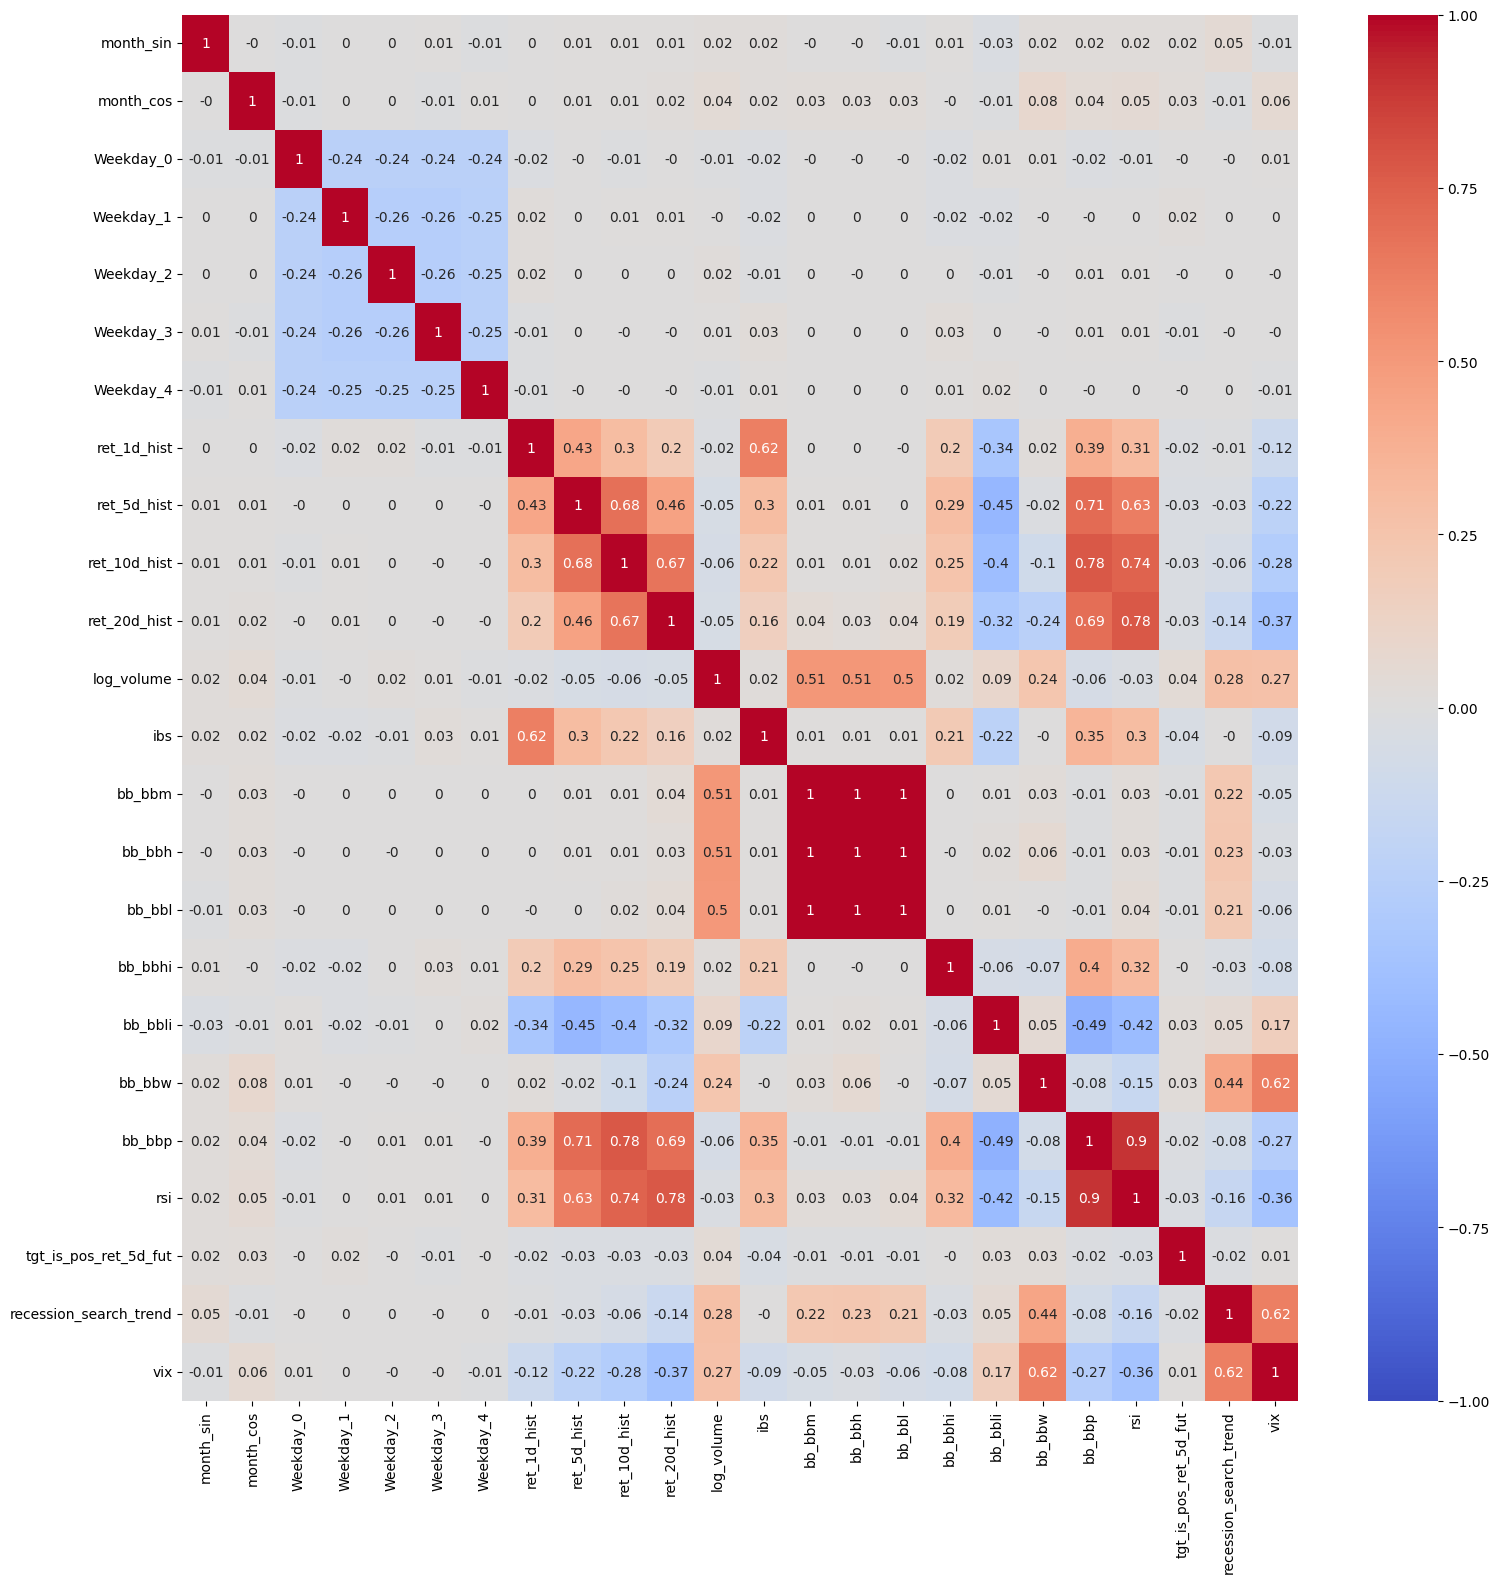

In [138]:
# Calculate the correlation matrix of the DataFrame
corr_matrix = data.corr().round(2)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Display the plot
plt.show()

In such scenarios, we usually eliminate all but one of the collinear features. Keep `bb_bbm` and drop the other two features that are highly linearly related to it.

In [139]:
# drio the 'bb_bbh' and 'bb_bbl' feature as they are highly collinier with bb_bbm
data.drop(columns=['bb_bbh', 'bb_bbl'], axis=1, inplace=True)

There is also one feature that is very highly correlated with `rsi` (which makes intuitive sense, as it, too, is a measure of relative strength). Find it an eliminate it, leaving `rsi` intact.

In [140]:
# 'bb_bbp' is hight correlated with 'rsi' with correlation score of 0.9. Therefore I will drop it.
data.drop(['bb_bbp'], axis=1, inplace=True)

Plot the heatmap of the new, reduced correlation matrix.

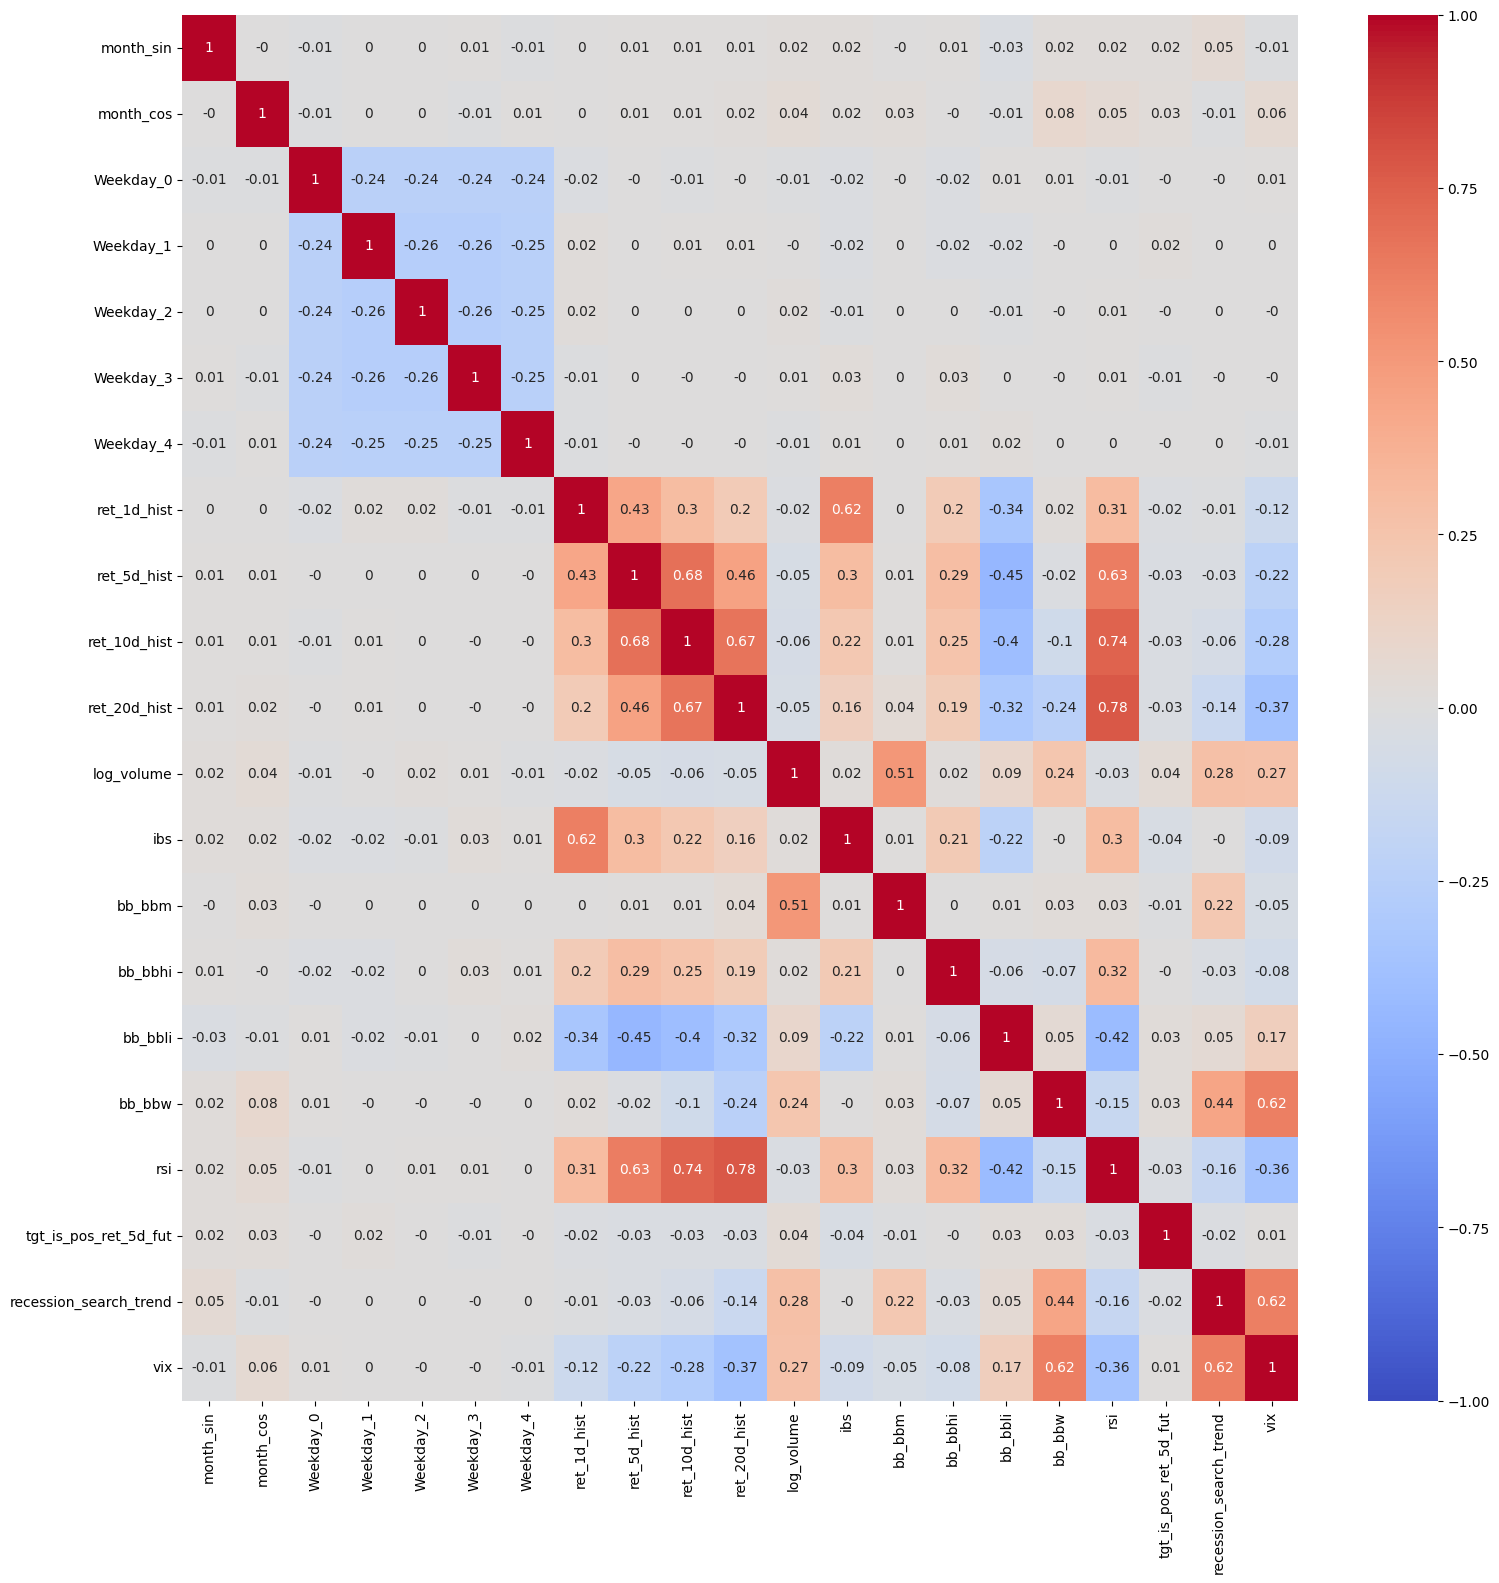

In [141]:
# Calculate the correlation matrix of the DataFrame
corr_matrix = data.corr().round(2)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Display the plot
plt.show()

Features that are highly correlated (negatively or positively) **with the target variable** are likely more important. Which two (2) independent variables (features) are correlated more than 4% (**in either direction**) with the boolean target variable denoting whether 5-day future returns are positive?


In [142]:
# Identify the correlation with the target variable (e.g., 'tgt_is_pos_ret_5d_fut')
target_corr = data.corr()['tgt_is_pos_ret_5d_fut']

# Filter independent variables with an absolute correlation greater than 0.04
important_features = target_corr[target_corr.abs() >= 0.04]

# Sort the results to find the top 2 most correlated features
important_features_sorted = important_features.drop('tgt_is_pos_ret_5d_fut').sort_values(ascending=False)

# Display the top 2 most correlated features
important_features_sorted.head(2)

log_volume    0.043164
ibs          -0.044293
Name: tgt_is_pos_ret_5d_fut, dtype: float64

In [143]:
data.corr()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbhi,bb_bbli,bb_bbw,rsi,tgt_is_pos_ret_5d_fut,recession_search_trend,vix
month_sin,1.000000,-0.001922,-0.009486,0.003895,0.003713,0.010691,-0.009175,0.003222,0.007440,0.011381,0.014308,0.015810,0.021645,-0.003838,0.007646,-0.027296,0.023806,0.018081,0.016087,0.048968,-0.007276
month_cos,-0.001922,1.000000,-0.006159,0.002433,0.003646,-0.007872,0.007758,0.001455,0.008464,0.012375,0.018033,0.038985,0.016942,0.032007,-0.002112,-0.008001,0.083422,0.050414,0.034075,-0.007130,0.057335
Weekday_0,-0.009486,-0.006159,1.000000,-0.243364,-0.243806,-0.241154,-0.239679,-0.023430,-0.003595,-0.005532,-0.003840,-0.013418,-0.019367,-0.004044,-0.022214,0.006415,0.008235,-0.013775,-0.000435,-0.001697,0.013640
Weekday_1,0.003895,0.002433,-0.243364,1.000000,-0.258597,-0.255785,-0.254220,0.020259,0.000303,0.005418,0.006602,-0.002768,-0.015546,0.001167,-0.018797,-0.019911,-0.002957,0.000159,0.020079,0.001291,0.000685
Weekday_2,0.003713,0.003646,-0.243806,-0.258597,1.000000,-0.256249,-0.254681,0.015159,0.004029,0.002894,0.001740,0.015235,-0.011283,0.000004,0.001278,-0.007291,-0.001932,0.005599,-0.001306,0.001710,-0.002058
Weekday_3,0.010691,-0.007872,-0.241154,-0.255785,-0.256249,1.000000,-0.251911,-0.007595,0.000758,-0.000276,-0.001942,0.005994,0.031687,0.001455,0.028208,0.003464,-0.004088,0.006843,-0.014012,-0.001440,-0.002372
Weekday_4,-0.009175,0.007758,-0.239679,-0.254220,-0.254681,-0.251911,1.000000,-0.005322,-0.001636,-0.002727,-0.002731,-0.005550,0.014138,0.001296,0.010993,0.017735,0.001021,0.000726,-0.004455,0.000067,-0.009511
ret_1d_hist,0.003222,0.001455,-0.023430,0.020259,0.015159,-0.007595,-0.005322,1.000000,0.426762,0.303798,0.203794,-0.023497,0.617212,0.000555,0.202863,-0.343373,0.018968,0.314261,-0.022092,-0.006567,-0.116359
ret_5d_hist,0.007440,0.008464,-0.003595,0.000303,0.004029,0.000758,-0.001636,0.426762,1.000000,0.680701,0.457821,-0.053293,0.302269,0.005005,0.292672,-0.450683,-0.022494,0.626422,-0.031627,-0.027051,-0.219705
ret_10d_hist,0.011381,0.012375,-0.005532,0.005418,0.002894,-0.000276,-0.002727,0.303798,0.680701,1.000000,0.666527,-0.063594,0.216726,0.013345,0.249807,-0.400991,-0.100759,0.743006,-0.032284,-0.059147,-0.280112


Answer:
    
    - Variables 'ibs' and 'log_volume' are the top two most correlated features.

## 3. The Training-Validation-Testing Split


In this section, you will split the `data` set into two sets: the training and validation set, and the testing set. You will then come up with a baseline score so that you have a reference point for evaluating your model's performance.

**Note:** Technically, since you are not going to use classical statistics-based time-series prediction methods (such as ARIMA), you can shuffle the data before splitting it. But for ease of interpretability and backtesting, you may as well keep the data in its original order. This is fine as long as the distributions of features and the target variable do not significantly shift over time. - And that is an important assumption related to drift analysis, which was covered in the course, but we will not get to in this project.

### 3.1. The Split


It is time to split the data, temporally, into the training + validation and testing sets. You will train and optimize (i.e. cross-validate) your model on the first 80% of the data, and use the remaining 20% for the test set (i.e. to evaluate the performance of your model). Use the `train_test_split()` method from scikit-learn's `model_selection` module to perform the split.
> **Note:** Please make sure to set `shuffle=False` and `random_state=RANDOM_STATE`.

In [144]:
y = data['tgt_is_pos_ret_5d_fut']
X = data.drop(['tgt_is_pos_ret_5d_fut'], axis=1)
X.head()

,month_sin,month_cos,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbhi,bb_bbli,bb_bbw,rsi,recession_search_trend,vix
Date,,,,,,,,,,,,,,,,,,,,
2004-02-02,0.866025,0.5,1,0,0,0,0,0.012911,0.006737,0.030203,0.038385,12.384637,0.785713,30.6570,1.0,0.0,4.491877,65.934002,4.0,17.110001
2004-02-03,0.866025,0.5,0,1,0,0,0,0.006374,0.019697,0.040185,0.040185,12.433208,0.947367,30.7180,1.0,0.0,5.093225,68.671296,4.0,17.340000
2004-02-04,0.866025,0.5,0,0,1,0,0,0.003166,0.031922,0.026238,0.040393,12.989746,0.605263,30.7795,1.0,0.0,5.692705,69.970574,4.0,17.870001
2004-02-05,0.866025,0.5,0,0,0,1,0,-0.005050,0.011878,0.019075,0.028721,12.376659,0.465118,30.8235,0.0,0.0,6.036698,65.303961,4.0,17.709999
2004-02-06,0.866025,0.5,0,0,0,0,1,0.007614,0.025177,0.031839,0.040970,12.868761,1.000000,30.8860,0.0,0.0,6.493843,68.678433,4.0,16.000000


In [145]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    shuffle=False, 
    random_state=RANDOM_SEED
)

# Display the shapes of the resulting datasets
print(f"Training + Validation set shape: {X_train_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Training + Validation set shape: (4055, 20)
Testing set shape: (1014, 20)


In [146]:
# #  DO NOT MODIFY - Features that were originally numeric (and not just 0 or 1)
# numeric_columns = ["ret_1d_hist", "ret_5d_hist", "ret_10d_hist", "ret_20d_hist", "log_volume", 'bb_bbm', 'bb_bbhi', 'bb_bbli', 'bb_bbw', 'rsi', 'recession_search_trend', 'vix']

# # DO NOT MODIFY - imports
# from sklearn.preprocessing import MinMaxScaler

# # FILL IN - Fit the MinMaxScaler on the training data, then transform the training AND test data using the fitted scaler
# scaler = MinMaxScaler()
# X_train_val[numeric_columns] = scaler.fit_transform(X_train_val[numeric_columns])
# X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

### 3.2. Baseline Model and Score


Earlier, you inspected the distribution of the target variable across the entire data set. Run the cell below to analyze at the distribution of the target variable in each split.

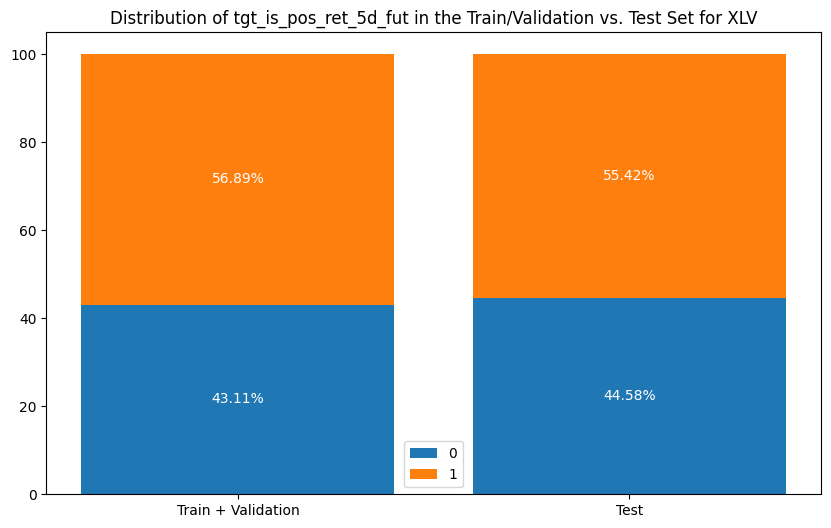

In [147]:
train_val_pct = y_train_val.value_counts(normalize=True) * 100
test_pct = y_test.value_counts(normalize=True) * 100

categories = ["Train + Validation", "Test"]
zero_counts = [train_val_pct[0], test_pct[0]]
one_counts = [train_val_pct[1], test_pct[1]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(categories, zero_counts, label="0")
ax.bar(categories, one_counts, bottom=zero_counts, label="1")

# Add text annotations
for i, (zero, one) in enumerate(zip(zero_counts, one_counts)):
    ax.text(i, zero / 2, f"{zero:.2f}%", ha="center", va="center", color="white")
    ax.text(
        i,
        zero + one / 2,
        f"{one:.2f}%",
        ha="center",
        va="center",
        color="white",
    )
ax.set_title(f"Distribution of {target_col_name} in the Train/Validation vs. Test Set for XLV")
ax.legend()

plt.show()

If you were to devise a simple model that naively always predicted the majority class, what would the accuracy score of your model be on the training+validation set? How about on the testing set? Consider the latter your baseline score, i.e. a reference score to compare your more sophisticated model's performace to.

In [148]:
baseline_accuracy_test_score = 0.5542

## 4. Model Training and Tuning


In this section, you will train a `RandomForestClassifier`, a robust, versatile ensemble learning method that uses "bagging" (also known as "bootstrap aggregating") to train multiple Decision Trees. The technical details of the model are beyond the scope of this course, but you may read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Run the cell below which defines a function that allows you to plot learning curves annotated with a hyperparameter named `max_depth` which you pass to it.

In [149]:
def plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axs.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    axs.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    axs.plot(
        train_sizes,
        train_scores_mean,
        "o-",
        color="b",
        label="Average Score on Training Sets",
    )
    axs.plot(
        train_sizes,
        test_scores_mean,
        "o-",
        color="r",
        label="Average Score on Test Sets",
    )
    axs.set_xlabel("Training examples")
    axs.set_ylabel("Score")
    axs.set_title(f"Learning Curves (max_depth={max_depth})")
    axs.legend(loc="center left")
    axs.grid(True)

Below is the first iteration of your model. It uses the default values for most of its hyperparameters. We have only specified one hyperparameter, `max_depth=10`.

In [150]:
max_depth = 10
model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)

Use the `learning_curve()` method from scikit-learn's `model_selection` module to cross-validate your model, with `accuracy` as the `scoring` metric. Use 10%, 20%, 30%,... , and 100% of the training+validatin data, with 5-fold cross-validation.

In [151]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train_val,
    y=y_train_val,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10%, 20%, ..., 100% of the training data
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    random_state=RANDOM_SEED
)

Inspect the learning curves.

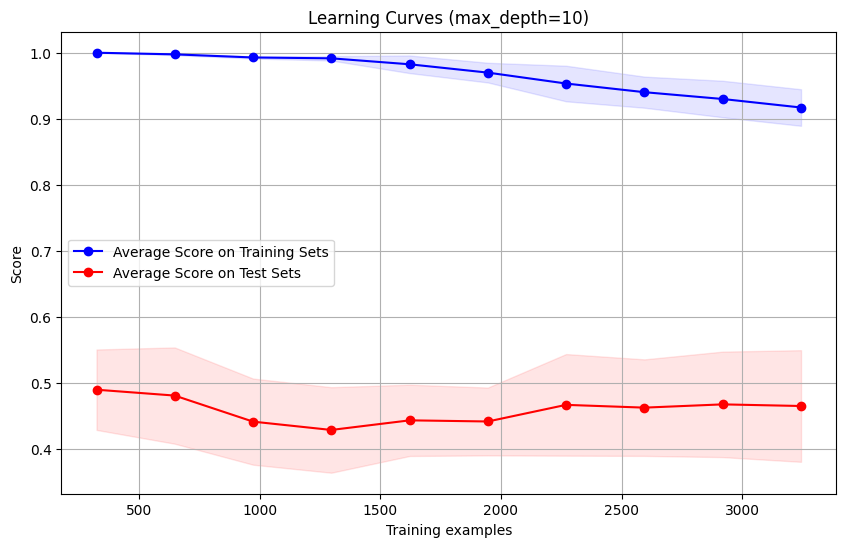

In [152]:
figure = plt.figure(figsize=(10, 6))
axs = figure.gca()

plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs)

plt.show()

Wondering what effect different values of the `max_depth` hyperparameter have, you decide to experiment with lower (`10`) and higher (`20`) values of it to see how the plots change. Run the cell below to help you answer the questions that follow it.


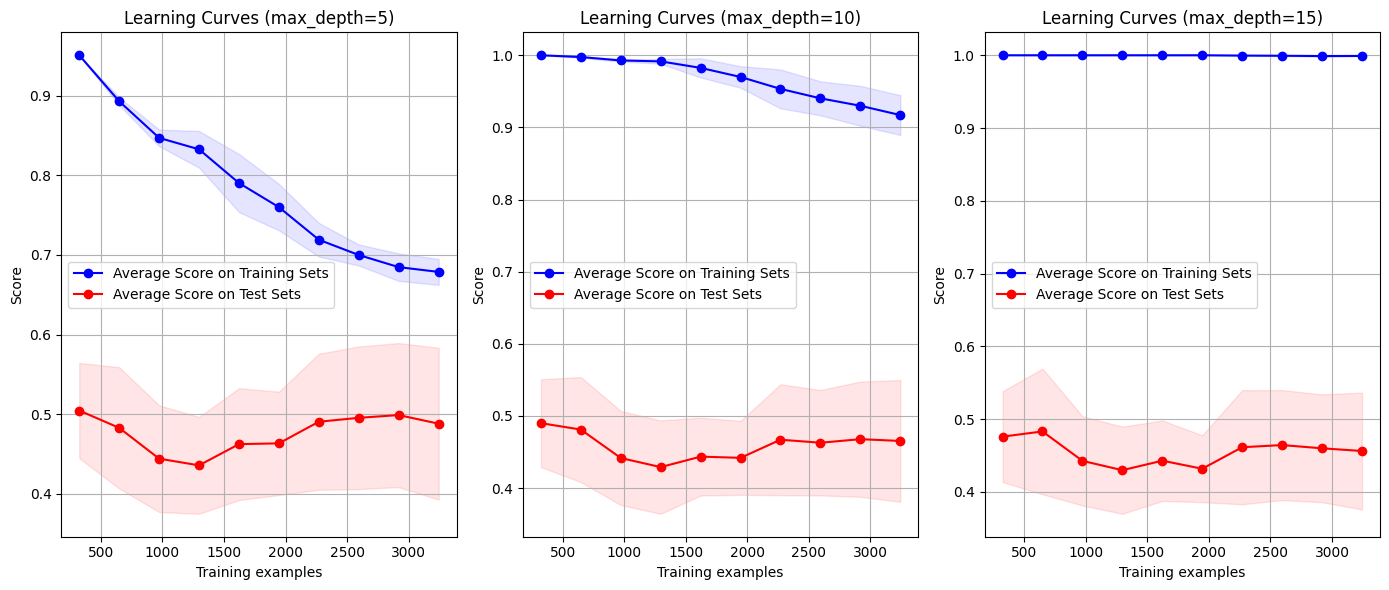

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
max_depth_range = [5, 10, 15]
for i, max_depth in enumerate(max_depth_range):
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_SEED, n_jobs=-1)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_val, y_train_val, train_sizes=train_sizes, cv=5, scoring="accuracy"
    )
    plot_learning_curves(train_sizes, train_scores, test_scores, max_depth, axs[i])

plt.tight_layout()
plt.show()

With a value of `max_depth=15`, does your model overfit or underfit?


Answer:
    
    - From the plot of max_depth=15, It is quite clear that the model is overfitting on the training data.

With a value of `max_depth=15`, is your performance metric (accuracy score) more likely to improve with more training data or with higher model complexity?

answer:
    
    - The model performanc will most likely increase with more data.
    - As the model is overfitting, it is likely memorizing the training data but not generalizing well to unseen data.
    - A max_depth=15 might already be too complex, which can result in high variance.
    - In this scenario, adding more training data can help the model generalize better, reduce overfitting, and improve the accuracy on the validation/test sets.



Random Forest Classifiers have several other hyperparameters, such as `min_samples_split` (default=2), `min_samples_leaf` (default=1) and `n_estimators` (default=100). So far, you have been tuning your model manually. But with all the possible combinations of hyperparameters, this is not tractable.  

Use grid search cross-validation (the `GridSearchCV` class from scikit-learn's `model_selection` module) to find the optimal combination of hyperparameters from the search space specified below:
- `max_depth` = 2, 3, 4 or 5
- `min_samples_leaf` = 1, 2, 3 or 4
- `n_estimators` = 50, 75, 100, 125, or 150

As before, use 5-fold cross-validation and accuracy as the `scoring` metric. Name your tuning model `search`.

> Note: Setting `n_jobs=-1` will allow Python to take advantage of parallel computing on your computer to speed up the training.

In [154]:
# Define the hyperparameter search space
param_grid = {
    'n_estimators': [50, 75, 100, 125, 150],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Define the model (RandomForestClassifier)
model = RandomForestClassifier(random_state=RANDOM_SEED)


# Set up the GridSearchCV object
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the scoring metric
    n_jobs=-1,  # Use all available cores for parallel processing
    verbose=1  # This will print out the progress
)

# Fit the GridSearchCV to the data (using training + validation set)
search.fit(X_train_val, y_train_val)

# Print the best parameters and the best accuracy score
print("Best hyperparameters:", search.best_params_)
print("Best accuracy score:", search.best_score_)
print("Best estimator:", search.best_estimator_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 50}
Best accuracy score: 0.4939580764488286
Best estimator: RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)


Run the cell below to see the top 5 best performing hyperparameter combinations.

In [155]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.217431,0.028891,0.013885,0.004809,2,1,50,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.453761,0.310727,0.568434,0.568434,0.568434,0.493958,0.101813,1
5,0.237383,0.055543,0.012311,0.005487,2,2,50,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.453761,0.310727,0.568434,0.568434,0.568434,0.493958,0.101813,1
15,0.195119,0.012897,0.010689,0.001706,2,4,50,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.453761,0.310727,0.568434,0.568434,0.568434,0.493958,0.101813,1
10,0.196076,0.003146,0.010018,0.000806,2,3,50,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.453761,0.310727,0.568434,0.568434,0.568434,0.493958,0.101813,1
75,0.352156,0.057138,0.010403,0.000880,5,4,50,"{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",0.443896,0.316893,0.561036,0.572133,0.572133,0.493218,0.100576,5


Looking at the results of GridSearchCV, which hyperparameters yield the highest mean test score?


In [156]:
best_max_depth = 2
best_min_samples_leaf = 1
best_n_estimators = 50

Looking more closely at the DataFrame of top 5 results, varying which hyperparameter did not seem to have any effect, at least in the top-ranking score?

answer = min_samples_leaf

## 5. Model Evaluation and Interpretation


In this section, you will evaluate the performance metrics of the best model you found in the previous section and analyze feature importance in relation to model performance.

### 5.1. Evaluation (Performance Metrics)


It is finally time to train your model on the entire training + validation set with the optimal set of hyperparameters you just found, and evaluate its performance on the test set.  

Train (`fit()`) a `RandomForestClassifier` on the training data with the optimal combination of hyperparameters you found in the previous section. Name it 'clf'.

> **Note:** Remember to set `random_state=RANDOM_SEED` for consistency of results, and set `n_jobs=-1` to automatically speed up the run.

In [157]:
clf = RandomForestClassifier(max_depth = 2,
                             min_samples_leaf = 1,
                             n_estimators = 50,
                             random_state=RANDOM_SEED)

clf.fit(X_train_val, y_train_val)

RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)

Store your trained model's predictions on the **testing** set in a variable named `y_test_pred`.

In [158]:
y_train_val_pred = clf.predict(X_train_val)
y_test_pred = clf.predict(X_test)

In [159]:
print(f"Accuracy on train set: {accuracy_score(y_train_val, y_train_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")

Accuracy on train set: 0.5704069050554871
Accuracy on test set: 0.5542406311637081


Complete the Python dictionary in the code cell below to evaluate your model and answer the questions that follow.

In [160]:
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
}
display(evaluation)

{'accuracy': 0.5542406311637081,
 'precision': 0.5545634920634921,
 'recall': 0.994661921708185,
 'f1': 0.7121019108280254}

Explain, in words and citing the actual numbers from the evaluation report above, what the **precision** and **recall** scores mean.

**Answer:**

- A precision value of 0.5546 means that when the model predicts when the stock price will go up in next 5 days it is correct 55% of the time.
  In other words, out of all the predictions the model made for the stock price to go up in next 5 days, 45% were actually incorrect (false positives).
- A recall value of 0.9946 means that the model correctly identified 99.46% of all the actual positive instances (the probability of stock price to go up in next 5 days).

Run the cell below to get a more detailed report.

In [161]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.01      0.01       452
           1       0.55      0.99      0.71       562

    accuracy                           0.55      1014
   macro avg       0.53      0.50      0.36      1014
weighted avg       0.53      0.55      0.40      1014



How many True Negatives, False Negatives, False Positives and True Positives did the model predict on the test set? Find out using the `confusion_matrix()` method from scikit-learn's `metrics` module. 

[[  3 449]
 [  3 559]]


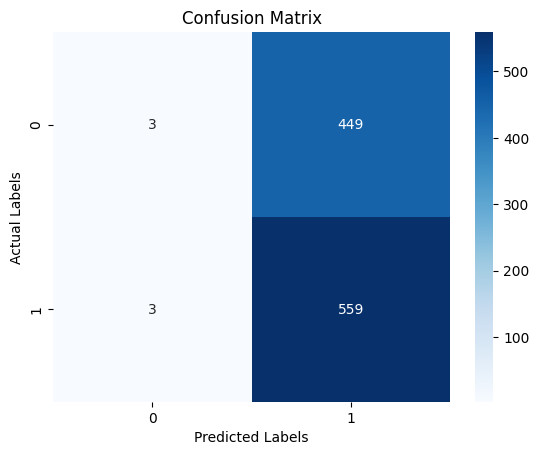

In [162]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    print(conf_mat)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_test, y_test_pred)


Answer the question from earlier.
> Note: Feel free to rename the variables. We will not reference them later.

In [163]:
num_TrueNeg = 3
num_FalseNeg = 3
num_FalsePos = 449
num_TruePos = 559

Is the model overfitting or underfitting? Did it manage to capture the variance on the training set but fail to generalize to the testing set? Take a look at the `classification_report()` and `confusion_matrix()` on the **training** data.

---

From the classification report and confusion matrix on the test data, we can observe the following:

Precision:

Class 0 (predicted down): Very low precision (0.50), meaning that when the model predicted a decrease in XLV’s price, it was rarely correct.
Class 1 (predicted up): Moderately better precision (0.55), suggesting it did a slightly better job predicting when the price would increase.
Recall:

Class 0: Very low recall (0.01), meaning the model almost never predicted when the price actually decreased. This indicates a strong bias towards predicting the price to increase.
Class 1: High recall (0.99), meaning the model correctly captured almost all cases where the price increased.
F1-Score:

Class 0: Very poor F1 score (0.01), suggesting that the model is almost incapable of predicting when the price will drop.
Class 1: Better F1 score (0.71) for predicting price increases, but not great overall.
Confusion Matrix:

The number of True Positives (559) and False Positives (449) suggests the model strongly favors predicting the price will go up (Class 1).
The number of True Negatives (3) and False Negatives (3) is extremely low, indicating that the model rarely predicts price decreases (Class 0).
Is the model overfitting or underfitting?
Based on these observations:

By taking a look at the classification report and confuction matrix on the training data we can conclude that: 
The model is clearly underfitting because it fails to capture the relationship for price decreases (Class 0) and simply defaults to predicting price increases (Class 1) for the vast majority of cases, both in the training and test datasets.
The high recall for Class 1 and very low performance on Class 0 shows that the model is overly simplistic and unable to capture the complexity of the problem.
The model seems to lack the necessary flexibility to differentiate between the two classes, which is a classic case of underfitting. It fails to generalize both in the training data and test data.

In [164]:
y_train_val_pred = clf.predict(X_train_val)
print(classification_report(y_train_val, y_train_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1748
           1       0.57      1.00      0.73      2307

    accuracy                           0.57      4055
   macro avg       0.78      0.50      0.37      4055
weighted avg       0.76      0.57      0.42      4055



In [165]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[   6, 1742],
       [   0, 2307]])

How does your model's performance compare to the baseline in terms of `accuracy`?


answer = 

    - The performance of the model compared to the baseline is almost same with an accuracy_score ~= .5542

How do the `precision` and `recall` of your model compare to those of the baseline model?

answer = 

    - The precision and recall of the model is slightly better compared to the baseline model.

### 5.2. Revisiting Feature Importance


You decide to see if there are any features that are not contributing significantly to the performance of the model. Use the `feature_importances_` property of your classifier.


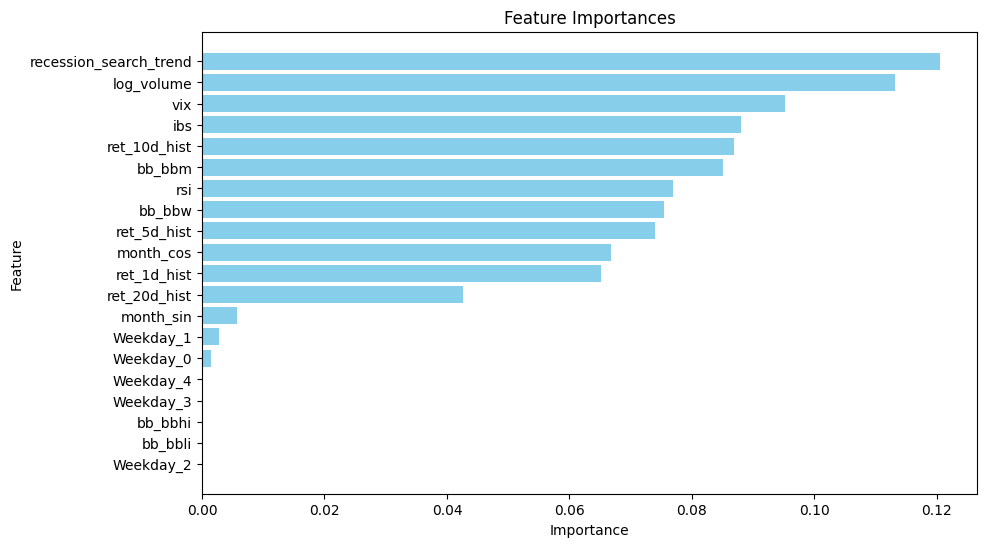

                   Feature  Importance
18  recession_search_trend    0.120542
11              log_volume    0.113146
19                     vix    0.095286
12                     ibs    0.088074
9             ret_10d_hist    0.086942
13                  bb_bbm    0.085113
17                     rsi    0.076874
16                  bb_bbw    0.075512
8              ret_5d_hist    0.073999
1                month_cos    0.066853
7              ret_1d_hist    0.065137
10            ret_20d_hist    0.042593
0                month_sin    0.005791
3                Weekday_1    0.002730
2                Weekday_0    0.001408
6                Weekday_4    0.000000
5                Weekday_3    0.000000
14                 bb_bbhi    0.000000
15                 bb_bbli    0.000000
4                Weekday_2    0.000000


In [166]:
# Assuming best_model is the trained RandomForestClassifier from GridSearchCV
feature_importances = clf.feature_importances_

# Create a DataFrame for the features and their importances
features = X_train_val.columns  # Extract feature names from the training data
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Display the sorted DataFrame
print(importances_df)

Create a new training set named `X_train_val_reduced` and a new testing set named `X_test_reduced` by eliminating any features from the old train/test sets that had a feature importance of less than `0.5%`.

In [167]:
# Drop features that have an importance of 0.05% or less...
feats_to_drop = ['bb_bbhi', 'bb_bbli', 'Weekday_4', 'Weekday_3', 'Weekday_2', 'Weekday_1', 'Weekday_0']
X_train_val_reduced = X_train_val.drop(columns=feats_to_drop, axis=1)
X_test_reduced = X_test.drop(columns=feats_to_drop, axis=1)

In [168]:
X_train_val_reduced.head()

,month_sin,month_cos,ret_1d_hist,ret_5d_hist,ret_10d_hist,ret_20d_hist,log_volume,ibs,bb_bbm,bb_bbw,rsi,recession_search_trend,vix
Date,,,,,,,,,,,,,
2004-02-02,0.866025,0.5,0.012911,0.006737,0.030203,0.038385,12.384637,0.785713,30.6570,4.491877,65.934002,4.0,17.110001
2004-02-03,0.866025,0.5,0.006374,0.019697,0.040185,0.040185,12.433208,0.947367,30.7180,5.093225,68.671296,4.0,17.340000
2004-02-04,0.866025,0.5,0.003166,0.031922,0.026238,0.040393,12.989746,0.605263,30.7795,5.692705,69.970574,4.0,17.870001
2004-02-05,0.866025,0.5,-0.005050,0.011878,0.019075,0.028721,12.376659,0.465118,30.8235,6.036698,65.303961,4.0,17.709999
2004-02-06,0.866025,0.5,0.007614,0.025177,0.031839,0.040970,12.868761,1.000000,30.8860,6.493843,68.678433,4.0,16.000000


Re-do your grid search cross-validation with the same grid of hyperparameters as before but with the **reduced** feature set.

In [169]:
model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

   
# Set up the GridSearchCV object
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the scoring metric
    n_jobs=-1,  # Use all available cores for parallel processing
    verbose=1  # This will print out the progress
)

# Fit the GridSearchCV to the data (using training + validation set)
search.fit(X_train_val_reduced, y_train_val)

# Print the best parameters and the best accuracy score
print("Best hyperparameters:", search.best_params_)
print("Best accuracy score:", search.best_score_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 75}
Best accuracy score: 0.49371146732429105


In [170]:
pd.DataFrame(search.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,0.466492,0.051496,0.043394,0.021696,2,4,100,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.456227,0.307028,0.568434,0.568434,0.568434,0.493711,0.102962,1
1,0.394762,0.050116,0.060489,0.031089,2,1,75,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",0.451295,0.311961,0.568434,0.568434,0.568434,0.493711,0.101571,1
6,0.457628,0.024269,0.045859,0.013838,2,2,75,"{'max_depth': 2, 'min_samples_leaf': 2, 'n_est...",0.451295,0.311961,0.568434,0.568434,0.568434,0.493711,0.101571,1
16,0.361676,0.012893,0.037323,0.006862,2,4,75,"{'max_depth': 2, 'min_samples_leaf': 4, 'n_est...",0.451295,0.311961,0.568434,0.568434,0.568434,0.493711,0.101571,1
11,0.352420,0.028998,0.040916,0.006992,2,3,75,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",0.451295,0.311961,0.568434,0.568434,0.568434,0.493711,0.101571,1


In [171]:
search.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 75}

Train a new classifier on the reduced feature set with the best hyperparameters combination from the new grid search and then inspect its accuracy on the test set (with the **reduced** feature set).

In [172]:
clf = RandomForestClassifier(max_depth = 2,
                             min_samples_leaf = 1,
                             n_estimators = 75,
                             random_state=RANDOM_SEED)
clf.fit(X_train_val_reduced, y_train_val)

RandomForestClassifier(max_depth=2, n_estimators=75, random_state=42)

In [173]:
y_test_reduced_pred = clf.predict(X_test_reduced)
evaluation = {
    "accuracy": accuracy_score(y_test, y_test_reduced_pred),
    "precision": precision_score(y_test, y_test_reduced_pred),
    "recall": recall_score(y_test, y_test_reduced_pred),
    "f1": f1_score(y_test, y_test_reduced_pred),
}
display(evaluation)

{'accuracy': 0.5621301775147929,
 'precision': 0.6,
 'recall': 0.6298932384341637,
 'f1': 0.6145833333333334}

In [174]:
# train set report
y_train_val_reduced_pred = clf.predict(X_train_val_reduced)
evaluation = {
    "accuracy": accuracy_score(y_train_val, y_train_val_reduced_pred),
    "precision": precision_score(y_train_val, y_train_val_reduced_pred),
    "recall": recall_score(y_train_val, y_train_val_reduced_pred),
    "f1": f1_score(y_train_val, y_train_val_reduced_pred),
}
display(evaluation)

{'accuracy': 0.5726263871763255,
 'precision': 0.5710747894997523,
 'recall': 0.9995665366276549,
 'f1': 0.7268715524034672}

In [175]:
print(classification_report(y_test, y_test_reduced_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49       452
           1       0.60      0.63      0.61       562

    accuracy                           0.56      1014
   macro avg       0.55      0.55      0.55      1014
weighted avg       0.56      0.56      0.56      1014



In [176]:
print(classification_report(y_train_val, y_train_val_reduced_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.01      0.02      1748
           1       0.57      1.00      0.73      2307

    accuracy                           0.57      4055
   macro avg       0.76      0.50      0.37      4055
weighted avg       0.73      0.57      0.42      4055



In [177]:
confusion_matrix(y_test, y_test_reduced_pred)

array([[216, 236],
       [208, 354]])

How does the accuracy compare to your last trained model?

answer =

    - After removing the features that were not contributing in the model prediction, the accuracy of the model seems to have increaded slightly to ~56.21%.

How does the accuracy compare to the baseline?

answer = 

    - The accuracy of the model is slightly better compared to the baseline as well.

Take a look at the classification report and confusion matrices on the **training data** with the **reduced feature set** as well:

In [179]:
y_train_val_pred = clf.predict(X_train_val_reduced)
print(classification_report(y_train_val, y_train_val_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.01      0.02      1748
           1       0.57      1.00      0.73      2307

    accuracy                           0.57      4055
   macro avg       0.76      0.50      0.37      4055
weighted avg       0.73      0.57      0.42      4055



In [180]:
confusion_matrix(y_train_val, y_train_val_pred)

array([[  16, 1732],
       [   1, 2306]])

What would your next course of action be? In particular, share your thoughts on the following:
- Further optimization of this model
- Pursuing a different trading strategy or market (instruments) altogether
- Anything else?

answer = 
Given the model's performance, my next course of action would focus on both optimizing the current approach and exploring alternative strategies. Here's a breakdown of the steps:

1. Further Optimization of the Current Model:

We have already looked into this aspect by using the GridSeach to find the best possible hyperparameter for the model.

Feature Engineering: We can try adding some additional features which might provided better resutls.

Technical indicators: Adding more technical analysis indicators like Moving Averages (SMA, EMA), Stochastic Oscillators, or MACD.
Lagged features: Include lagged versions of existing features (e.g., price or volatility lagged by n days) to help capture short-term trends.

2. Pursuing a different trading strategy or market (instruments) altogether

Alternative Trading Strategies:

Instead of a classification model, we can consider using regression models to predict the magnitude of price changes rather than just the direction. 
This might help capture more meaningful signals for trading strategies.

Explore momentum-based strategies using technical indicators like the Relative Strength Index (RSI) or Bollinger Bands for trading decisions.

Pair trading: Consider using pair trading strategies where the model focuses on the relative performance of two related assets rather than predicting absolute direction.

3. Exploring Alternative Models

Ensemble Models: While Random Forest is an ensemble model, it might be worth trying more sophisticated ensemble techniques like:

- Gradient Boosting Machines (GBM)
- XGBoost or LightGBM
- CatBoost, which tends to perform well on tabular data.
- Neural Networks: If more data is available, you could explore neural networks, especially recurrent neural networks (RNNs) or long short-term memory (LSTM) models, which are good for time-series prediction.

AutoML: Consider using AutoML frameworks like H2O.ai or TPOT to automate the process of model selection and hyperparameter tuning.

What do you think of the fact that we used interpolated **monthly** Google Trends data to try and predict short-term (5-day) price movements?

Answer:

Using interpolated monthly Google Trends data to predict short-term (5-day) price movements poses several challenges that could impact the model's effectiveness. Here's an evaluation of this approach:
1. Mismatch in Time Granularity:
    - Google Trends data is monthly, meaning it represents search interest over a longer, less granular time period, while the stock price movements we're predicting are happening at a 5-day interval. This creates a mismatch between the frequency of the data and the prediction window.
    - Issue: Monthly data likely won't capture the rapid fluctuations and short-term sentiment shifts that can drive stock price movements over a few days. The underlying assumption that monthly trends affect short-term movements may not hold true, as daily market sentiment can change based on news, events, or other short-term factors.

2. Lagging Indicators and Timing Issues:
    - Google Trends data, especially for a broad term like "recession," might not respond quickly enough to reflect real-time market conditions, particularly for stock price movements that can shift on a much smaller timescale.
    - Issue: By the time changes in Google search trends reflect a potential economic concern (like an impending recession), short-term market movements may have already occurred. This lag reduces the predictive power of the data when applied to a 5-day forecast.

3. Interpolation of Monthly Data:
    - Interpolating monthly Google Trends data to create daily or 5-day estimates could introduce noise or artificial patterns that aren't reflective of actual market dynamics.
    - Issue: The interpolation might smooth out important shifts in search interest or introduce misleading trends, further reducing the relevance of the data for short-term price movement predictions.

4. Google Trends Data May Reflect Broader Trends:
    - The search term "recession" is a broad, macroeconomic indicator. While it can provide insight into general market sentiment, it might not capture the sector-specific or short-term catalysts that impact the healthcare sector or the specific ETF we're analyzing (XLV).
    - Issue: The general public's concern about a recession might correlate with broader market conditions, but it could miss sector-specific factors, such as policy changes or healthcare earnings reports, that might drive XLV’s price in the short term.

5. Overfitting Potential:
    - By using monthly Google Trends data in a model that is designed to predict short-term outcomes, there is a risk of overfitting the noise or irrelevant signals in the data, rather than capturing meaningful relationships between market sentiment and short-term stock movements.

## Conclusion

These results highlight the challenges in consistently training AI/ML models that outperform naive baseline scores in financial markets due to factors such as non-stationary data, low signal-to-noise ratio, high market efficiency, and a competitive and adversarial trading environment. It would be necessary to gather much more data (and higher quality data) than we have in this project, and to engineer much more complex features and models to eke out even a slight gain in performance. It is therefore essential to use your domain knowledge, have realistic expectations, and constantly monitor your modeling assumptions and metrics. We hope that this project enables you to do so by giving you the tools, techniques and ideas to keep in mind.